In [1]:
import pandas as pd
import numpy as np
import json
from IPython.display import HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from gensim.similarities import MatrixSimilarity
from gensim import corpora
from operator import itemgetter
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
import re

## Getting and flattening data 

In [2]:
# loading all json file to article data
with open('data/response2023_08.json', 'r') as f:
    article_data = json.load(f)
    f.close()

In [5]:
print(json.dumps(article_data, indent=4))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
# getting all the necessary information from the json data that was obtained from new york times api 

i = 0
j = 0
data_rows = []
while i < len(article_data['response']['docs']): # looping through the articles

    extracted_data = {
        "abstract": article_data["response"]["docs"][i]["abstract"],
        "web_url": article_data["response"]["docs"][i]["web_url"],
        "lead_paragraph": article_data["response"]["docs"][i]["lead_paragraph"],
        "headline": article_data["response"]["docs"][i]["headline"]["main"],
        "authors": article_data["response"]["docs"][i]["byline"]["original"],
        "word_count": article_data["response"]["docs"][i]["word_count"]
    }

    while j < len(article_data['response']['docs'][i]['keywords']): # looping through the keywords within the article
        extracted_data[f'category{j}'] = article_data['response']['docs'][i]['keywords'][j]['value']
        j += 1
    j = 0
    data_rows.append(extracted_data)
    i += 1


## Data wrangling and EDA

In [5]:
data_rows

[{'abstract': 'The Pentagon said the decision was because of military readiness, but it comes as the Republican senator from Alabama has held up military promotions to protest an abortion access policy.',
  'web_url': 'https://www.nytimes.com/2023/07/31/us/biden-space-force-alabama-colorado.html',
  'lead_paragraph': 'The Pentagon announced on Monday that President Biden had canceled an order by former President Donald J. Trump to move the United States Space Command headquarters to Alabama, prompting an outcry from Republicans who accused him of acting out of political spite amid a fierce partisan standoff over the Pentagon’s abortion access policies.',
  'headline': 'Biden Cancels Space Command Move to Alabama Amid Tuberville Feud',
  'authors': 'By Karoun Demirjian',
  'word_count': 735,
  'category0': 'United States Politics and Government',
  'category1': 'United States Defense and Military Forces',
  'category2': 'Abortion',
  'category3': 'United States Space Force',
  'category

In [6]:
len(data_rows)

3668

In [4]:
article_df = pd.DataFrame(data_rows)

In [83]:
# checking for null values
article_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668 entries, 0 to 3667
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   abstract        3668 non-null   object
 1   web_url         3668 non-null   object
 2   lead_paragraph  3668 non-null   object
 3   headline        3668 non-null   object
 4   authors         3668 non-null   object
 5   word_count      3668 non-null   int64 
 6   category0       3432 non-null   object
 7   category1       3302 non-null   object
 8   category2       3138 non-null   object
 9   category3       2938 non-null   object
 10  category4       2621 non-null   object
 11  category5       2240 non-null   object
 12  category6       1833 non-null   object
 13  category7       1438 non-null   object
 14  category8       1066 non-null   object
 15  category9       763 non-null    object
 16  category10      549 non-null    object
 17  category11      376 non-null    object
 18  category

In [9]:
article_df = article_df.iloc[:, 0:9]

In [10]:
# basic descriptive statistics of the numeric data
article_df['word_count'].describe()

count     3668.000000
mean       931.435115
std        791.921348
min          0.000000
25%        515.000000
50%        875.000000
75%       1225.000000
max      15366.000000
Name: word_count, dtype: float64

In [11]:
# dropping all the rows that have a word count of 0 or less
column = article_df.word_count
zero_words = column[column <= 0]
article_df.drop(zero_words.index, inplace=True)
article_df.reset_index(drop=True, inplace=True)

In [12]:
HTML(article_df.head().to_html())

,abstract,web_url,lead_paragraph,headline,authors,word_count,category0,category1,category2
0,"The Pentagon said the decision was because of military readiness, but it comes as the Republican senator from Alabama has held up military promotions to protest an abortion access policy.",https://www.nytimes.com/2023/07/31/us/biden-space-force-alabama-colorado.html,"The Pentagon announced on Monday that President Biden had canceled an order by former President Donald J. Trump to move the United States Space Command headquarters to Alabama, prompting an outcry from Republicans who accused him of acting out of political spite amid a fierce partisan standoff over the Pentagon’s abortion access policies.",Biden Cancels Space Command Move to Alabama Amid Tuberville Feud,By Karoun Demirjian,735,United States Politics and Government,United States Defense and Military Forces,Abortion
1,He played dozens of memorable roles on big and small screens throughout his career. We’ve rounded up what to watch and where to watch it.,https://www.nytimes.com/2023/07/31/arts/television/paul-reuben-pee-wee-herman-movies-tv-shows.html,"Paul Reubens, who died on Sunday at age 70, will always be remembered for his beloved alter ego, the perpetually childlike Pee-wee Herman — a character so popular that it was able to carry a stage show, movies and a TV series. But Reubens also made memorable impressions playing a variety of supporting characters of the big and small screens — like Penguin’s father in “Batman Returns” and the turtleneck-wearing fixer Mr. Vargas in “The Blacklist,” just to name a few out of dozens.",Paul Reubens Was More Than Pee-wee. Here are 8 Great Performances.,By Elisabeth Vincentelli,817,Television,Movies,"Reubens, Paul"
2,Kathryn Ladner branches out.,https://www.nytimes.com/2023/07/31/crosswords/daily-puzzle-2023-08-01.html,Jump to: Today’s Theme | Tricky Clues | Solving Tip,"Crunch Muscles, for Short",By Sam Corbin,929,Crossword Puzzles,NaN,NaN
3,The scramble to cover legal bills for former President Donald J. Trump and his associates has prompted what appears to be the largest refund in federal campaign finance history.,https://www.nytimes.com/2023/07/31/us/politics/trump-pac-filing.html,"Former President Donald J. Trump’s political action committee, which began last year with $105 million, now has less than $4 million left in its account after paying tens of millions of dollars in legal fees for Mr. Trump and his associates.","After Paying Lawyers, Trump’s PAC Is Nearly Broke","By Maggie Haberman, Shane Goldmacher and Jonathan Swan",1261,Campaign Finance,Presidential Election of 2024,Federal Criminal Case Against Trump (Documents Case)
4,The details of Ukraine’s drone strikes.,https://www.nytimes.com/2023/07/31/briefing/ukraine-strikes-trump-myanmar.html,"A Times investigation found evidence that at least three different Ukrainian-made drone models had been used in attacks inside Russia, including Moscow, indicating a Ukrainian role in strikes that Kyiv has denied carrying out or declined to claim responsibility for. Ukraine is racing to scale up its drone fleet, and to attack more frequently in Russia.",Tuesday Briefing,By Natasha Frost,1049,NaN,NaN,NaN


In [13]:
# replacing all the null values with an empty string
article_df.fillna('', inplace=True)

## Text preprocessing

In [14]:
# loading spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [15]:
# Punctuations to be removed from corpus
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# Stop words to be removed from corpus
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [17]:
def spacy_tokenizer(sentence):
    """ 
    This function cleans text and then tokenizes it
    """
    # removing single quotes 
    sentence = re.sub("'", "", sentence)

    # removing string containing numeric values
    sentence = re.sub('\w*\d\w*', '', sentence)

    # removing extra spaces
    sentence = re.sub(' +', ' ', sentence)

    # removing unwanted lines starting with special characters
    sentence = re.sub(r'\n: \'\'.*', '', sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    # removing non-breaking new line characters
    sentence = re.sub(r'\n', ' ', sentence)

    # removing punctuations
    sentence = re.sub(r'[^\w\s]', ' ', sentence)

    # tokenizing sentence
    tokens = spacy_nlp(sentence)

    # lower, strip and lemmatize text
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    # remove stopwords, and exvlude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation and len(word) > 2]

    return tokens



In [18]:
# applying the spacy tokenizer function on the lead paragraph
article_df['preprocessed_lead_para'] = article_df['lead_paragraph'].map(lambda x: spacy_tokenizer(x)).copy()

In [19]:
HTML(article_df[['preprocessed_lead_para', 'lead_paragraph']].head().to_html())

,preprocessed_lead_para,lead_paragraph
0,"[pentagon, announce, monday, president, biden, cancel, order, president, donald, trump, united, states, space, command, headquarters, alabama, prompt, outcry, republicans, accuse, act, political, spite, amid, fierce, partisan, standoff, pentagon, abortion, access, policy]","The Pentagon announced on Monday that President Biden had canceled an order by former President Donald J. Trump to move the United States Space Command headquarters to Alabama, prompting an outcry from Republicans who accused him of acting out of political spite amid a fierce partisan standoff over the Pentagon’s abortion access policies."
1,"[paul, reubens, die, sunday, age, remember, beloved, alter, ego, perpetually, childlike, pee, wee, herman, character, popular, able, carry, stage, movie, series, reubens, memorable, impression, play, variety, support, character, big, small, screen, like, penguin, father, batman, returns, turtleneck, wear, fixer, vargas, blacklist, dozen]","Paul Reubens, who died on Sunday at age 70, will always be remembered for his beloved alter ego, the perpetually childlike Pee-wee Herman — a character so popular that it was able to carry a stage show, movies and a TV series. But Reubens also made memorable impressions playing a variety of supporting characters of the big and small screens — like Penguin’s father in “Batman Returns” and the turtleneck-wearing fixer Mr. Vargas in “The Blacklist,” just to name a few out of dozens."
2,"[jump, today, theme, tricky, clues, solve, tip]",Jump to: Today’s Theme | Tricky Clues | Solving Tip
3,"[president, donald, trump, political, action, committee, begin, year, million, million, leave, account, pay, million, dollar, legal, fee, trump, associate]","Former President Donald J. Trump’s political action committee, which began last year with $105 million, now has less than $4 million left in its account after paying tens of millions of dollars in legal fees for Mr. Trump and his associates."
4,"[times, investigation, find, evidence, different, ukrainian, drone, model, use, attack, inside, russia, include, moscow, indicate, ukrainian, role, strike, kyiv, deny, carry, decline, claim, responsibility, ukraine, race, scale, drone, fleet, attack, frequently, russia]","A Times investigation found evidence that at least three different Ukrainian-made drone models had been used in attacks inside Russia, including Moscow, indicating a Ukrainian role in strikes that Kyiv has denied carrying out or declined to claim responsibility for. Ukraine is racing to scale up its drone fleet, and to attack more frequently in Russia."


In [20]:
# Assigning preprocessed data to a variable
lead_para = article_df['preprocessed_lead_para']

In [21]:
# To visualise most frequent occuring words throught the vocabulary
series = pd.Series(np.concatenate(lead_para)).value_counts()[:100]
print(series)

year         627
new          544
president    345
trump        322
week         284
            ... 
town          92
place         92
island        91
set           90
war           89
Name: count, Length: 100, dtype: int64


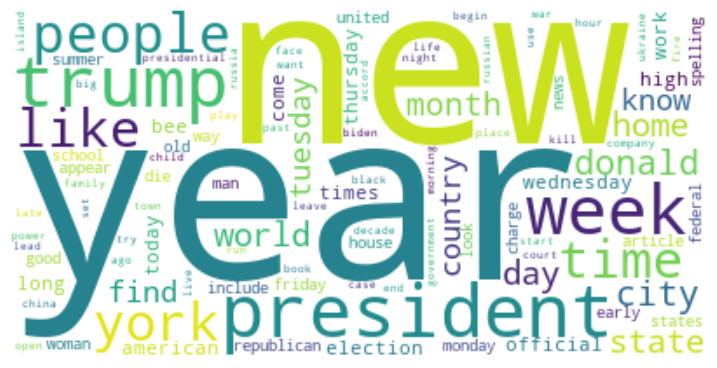

In [22]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)
plt.figure(figsize=(9,9), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# Creating a term dictionary that has all the unique vocabularies(tokens) and index(ID) of each token
dictionary = corpora.Dictionary(lead_para)

In [24]:
# Printing top 50 item from the dictionary of vocabulary
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
dict_tokens

[[['abortion', 0],
  ['access', 1],
  ['accuse', 2],
  ['act', 3],
  ['alabama', 4],
  ['amid', 5],
  ['announce', 6],
  ['biden', 7],
  ['cancel', 8],
  ['command', 9],
  ['donald', 10],
  ['fierce', 11],
  ['headquarters', 12],
  ['monday', 13],
  ['order', 14],
  ['outcry', 15],
  ['partisan', 16],
  ['pentagon', 17],
  ['policy', 18],
  ['political', 19],
  ['president', 20],
  ['prompt', 21],
  ['republicans', 22],
  ['space', 23],
  ['spite', 24],
  ['standoff', 25],
  ['states', 26],
  ['trump', 27],
  ['united', 28],
  ['able', 29],
  ['age', 30],
  ['alter', 31],
  ['batman', 32],
  ['beloved', 33],
  ['big', 34],
  ['blacklist', 35],
  ['carry', 36],
  ['character', 37],
  ['childlike', 38],
  ['die', 39],
  ['dozen', 40],
  ['ego', 41],
  ['father', 42],
  ['fixer', 43],
  ['herman', 44],
  ['impression', 45],
  ['like', 46],
  ['memorable', 47],
  ['movie', 48],
  ['paul', 49],
  ['pee', 50]]]

In [25]:
# Representing text as bag of words
corpus = [dictionary.doc2bow(text) for text in lead_para]

In [26]:
# glimps of frequence of each word in a paragraph
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus]
print(word_frequencies)

[[('abortion', 1), ('access', 1), ('accuse', 1), ('act', 1), ('alabama', 1), ('amid', 1), ('announce', 1), ('biden', 1), ('cancel', 1), ('command', 1), ('donald', 1), ('fierce', 1), ('headquarters', 1), ('monday', 1), ('order', 1), ('outcry', 1), ('partisan', 1), ('pentagon', 2), ('policy', 1), ('political', 1), ('president', 2), ('prompt', 1), ('republicans', 1), ('space', 1), ('spite', 1), ('standoff', 1), ('states', 1), ('trump', 1), ('united', 1)], [('able', 1), ('age', 1), ('alter', 1), ('batman', 1), ('beloved', 1), ('big', 1), ('blacklist', 1), ('carry', 1), ('character', 2), ('childlike', 1), ('die', 1), ('dozen', 1), ('ego', 1), ('father', 1), ('fixer', 1), ('herman', 1), ('impression', 1), ('like', 1), ('memorable', 1), ('movie', 1), ('paul', 1), ('pee', 1), ('penguin', 1), ('perpetually', 1), ('play', 1), ('popular', 1), ('remember', 1), ('returns', 1), ('reubens', 2), ('screen', 1), ('series', 1), ('small', 1), ('stage', 1), ('sunday', 1), ('support', 1), ('turtleneck', 1),

Building Tf-Idf and LSI Model

In [62]:
article_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
article_lsi_model = gensim.models.LsiModel(article_tfidf_model[corpus], id2word=dictionary, num_topics=30)

In [63]:
# for ease of access of model later
gensim.corpora.MmCorpus.serialize('article_tfidf_model_mm', article_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('article_lsi_model_mm', article_lsi_model[article_tfidf_model[corpus]])

In [64]:
# Loads the indexed corpus 
article_tfidf_corpus = gensim.corpora.MmCorpus('article_tfidf_model_mm')
article_lsi_corpus = gensim.corpora.MmCorpus('article_lsi_model_mm')

print(article_tfidf_corpus)
print(article_lsi_corpus) #fewer features since dimintionality has been reduced.

MmCorpus(3419 documents, 13638 features, 74872 non-zero entries)
MmCorpus(3419 documents, 30 features, 102210 non-zero entries)


In [65]:
def article_index():
    global article_index
    article_index = MatrixSimilarity(article_lsi_corpus, num_features = article_lsi_corpus.num_terms)

article_index()

In [75]:
def search_similar_articles(search_term):
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = article_tfidf_model[query_bow]
    query_lsi = article_lsi_model[query_tfidf]

    article_index.num_best = 5

    article_list = article_index[query_lsi]

    article_list.sort(key=itemgetter(1), reverse=True)
    articles = []

    for j, article in enumerate(article_list):
        articles.append(
            {
                'Relevence': round((article[1]*100), 2),
                'Headline': article_df['headline'][article[0]],
                'Lead Paragraph': article_df['lead_paragraph'][article[0]]
            }
        )
        if j == (article_index.num_best-1):
            break
    
    return pd.DataFrame(articles, columns=['Revelence', 'Headline', 'Lead Paragraph'])

In [76]:
article_df.columns

Index(['abstract', 'web_url', 'lead_paragraph', 'headline', 'authors',
       'word_count', 'category0', 'category1', 'category2', 'category3',
       'category4', 'category5', 'category6', 'category7', 'category8',
       'category9', 'category10', 'category11', 'category12', 'category13',
       'category14', 'category15', 'category16', 'category17', 'category18',
       'category19', 'category20', 'category21', 'category22', 'category23',
       'category24', 'category25', 'category26', 'category27', 'category28',
       'category29', 'category30', 'category31', 'category32', 'category33',
       'category34', 'category35', 'category36', 'category37', 'category38',
       'category39', 'category40', 'category41', 'category42', 'category43',
       'category44', 'category45', 'category46', 'category47', 'category48',
       'category49', 'category50', 'category51', 'category52', 'category53',
       'category54', 'category55', 'category56', 'category57', 'category58',
       'categor

In [77]:
HTML(search_similar_articles('stocks').to_html())

NameError: name 'dictionary' is not defined

In [13]:
listed = article_df['lead_paragraph'].tolist()

In [9]:
from sentence_transformers import SentenceTransformer, util

/Users/dhruvinandipara/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torch

In [11]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [20]:
paragraph = model.encode(listed)

In [39]:
def embedings(search_term):
    query = model.encode(search_term)
    similarity = util.dot_score(query, paragraph)
    similarity = similarity[0]
    values, indexes = torch.topk(similarity, 5)
    indexes = indexes.tolist()
    df = article_df.iloc[indexes][['headline', 'lead_paragraph']]
    df['Relevance'] = values.tolist()
    return  df[[ 'headline', 'lead_paragraph']]

In [41]:
HTML(embedings('Marvel').to_html())

,headline,lead_paragraph
2723,A Fan Made a Spider-Man Film. The Fallout Has Been Unexpected.,"In 2020, Gavin J. Konop, a high school junior in Rancho Cucamonga, Calif., was going through a rough patch in life — his grades were dipping, and his friendships strained — so he decided to create a film about his favorite superhero: Spider-Man."
482,5 Things to Do This Weekend,"Selections from the Weekend section, including a review of ""Teenage Mutant Ninja Turtles: Mutant Mayhem."""
1912,‘Blue Beetle’ Review: A Hero Story That’s All in the Family,Here’s what Warner Bros. and DC think we need: another superhero movie about an earnest young man suddenly forced to shoulder responsibility and fight for justice.
2025,‘The Monkey King’ Review: Wrenching the Zen of the Gods,"How loose is Anthony Stacchi’s brash retelling of the adventures of Sun Wukong, the famed Monkey King from the 16th-century Chinese novel “Journey to the West”? I’ll give you an example: The monkey’s powerful staff, a weapon called the Ruyi Jingu Bang, has, through the years, been referred to as the Compliant Golden-Hooped Rod and the As-You-Will-Gold-Banded Cudgel. Here, it’s called Stickipoo — and if its robotic squawks and light-saber glow appear on loan from George Lucas, that’s only fair. “Star Wars” borrowed the Force from Daoism; now, this cacophonous kids’ cartoon asserts its lead as a foundational superhero."
1090,"For Disney, Streaming Losses and TV’s Decline Are a One-Two Punch",Robert A. Iger’s urgent need to overhaul Disney — to turn its streaming division into a profitable enterprise and pull back on its troubled traditional television business — came into sharp relief on Wednesday.
